# 표준선 이미지 k-mean clustering

. here    
.. └ images    
.. ├ label   

## 1. 라이브러리 import

In [39]:
import json
import cv2
import os
import random
from glob import glob
from tqdm import tqdm
import numpy as np
import pprint
import seaborn as sns
import pandas as pd
import warnings
import sklearn
from sklearn.cluster import KMeans

import multiprocessing
from multiprocessing import (Pool, Process, cpu_count)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from colormap import hex2rgb

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['figure.figsize'] = (12, 12)

In [40]:
pp = pprint.PrettyPrinter(indent=4)

## 2. 경로 설정 및 파일 유실 유무 확인하기

In [41]:
!pwd

/home/yjyou/project/2022/Hi-NAS/표준선/이미지분석


In [42]:
# label json path를 알 수 있다
RAW_JSON_PATH = './label/meta/avikus_first-data/20210819/batch1/rawdata-16221/'
# 실제 bbox 정보를 알 수 있다
BASE_IMAGE_PATH = './images/'
LABEL_JSON_PATH = './label/labels/'

In [43]:
raw_jsons = glob(RAW_JSON_PATH+"*.json")
pp.pprint(f"raw_jsons: {raw_jsons[:5]}")

('raw_jsons: '
 "['./label/meta/avikus_first-data/20210819/batch1/rawdata-16221/[img_04118]_66_GP045503.MP4_8851.jpg.json', "
 "'./label/meta/avikus_first-data/20210819/batch1/rawdata-16221/[img_06023]_GOPR3820.mkv_000009917.jpg.json', "
 "'./label/meta/avikus_first-data/20210819/batch1/rawdata-16221/[img_11546]_VIDEO_04-22_170551.avi_000057200.jpg.json', "
 "'./label/meta/avikus_first-data/20210819/batch1/rawdata-16221/[img_09830]_GP145448_1260.jpg.json', "
 "'./label/meta/avikus_first-data/20210819/batch1/rawdata-16221/[img_09085]_GP105448_81.jpg.json']")


In [44]:
# 샘플 meta 데이터 참고
with open(raw_jsons[0]) as f:
    data = json.load(f)
    pp.pprint(data)

{   'data_key': '20210819/batch1/rawdata-16221/[img_04118]_66_GP045503.MP4_8851.jpg',
    'dataset': 'avikus_first-data',
    'image_info': {'height': 1080, 'width': 1920},
    'label_id': 'cdfe617e-e723-47ed-8045-11a34b4ca21b',
    'label_path': ['labels/cdfe617e-e723-47ed-8045-11a34b4ca21b.json'],
    'last_updated_date': '2022-02-04T07:10:46.852568Z',
    'status': 'SUBMITTED',
    'tags': [{'id': '55acf62a-9280-4ce9-b8d7-ccfe84435445', 'name': '3.4'}],
    'work_assignee': 'huiju150223@gmail.com'}


### 16000여개 중 라벨링이 필요없는 데이터를 제거하여 약 11000장 정도

In [45]:
print(f"총 json 파일 갯수: {len(raw_jsons)}")
cnt=0

for json_file in tqdm(raw_jsons):
    with open(json_file) as f:
        data = json.load(f)
#         pp.pprint(data)

        img_path = os.path.join(BASE_IMAGE_PATH, os.path.basename(data['data_key']))
        cnt += os.path.exists(img_path)
#         print(f"이미지 파일 경로: {img_path}, 유무: {os.path.exists(img_path)}")

print(f"이미지 유: {cnt}, 무: {len(raw_jsons)-cnt}")

총 json 파일 갯수: 14196


100%|███████████████████████████| 14196/14196 [00:00<00:00, 41064.79it/s]

이미지 유: 11028, 무: 3168


### label 데이터는 이미지와 다르게 모두 존재

In [46]:
print(f"총 json 파일 갯수: {len(raw_jsons)}")
cnt=0
label_cnt=0

for json_file in tqdm(raw_jsons):
    with open(json_file) as f:
        data = json.load(f)
#         pp.pprint(data)

        img_path = os.path.join(BASE_IMAGE_PATH, os.path.basename(data['data_key']))
        label_path = os.path.join(LABEL_JSON_PATH, os.path.basename(data['label_path'][0]))
        cnt += os.path.exists(img_path)
        label_cnt += os.path.exists(label_path)
#         print(f"이미지 파일 경로: {img_path}, 유무: {os.path.exists(img_path)}")

print(f"이미지 유: {cnt}, 무: {len(raw_jsons)-cnt}")
print(f"레이블 유: {label_cnt}, 무: {len(raw_jsons)-label_cnt}")

총 json 파일 갯수: 14196


100%|███████████████████████████| 14196/14196 [00:00<00:00, 36518.15it/s]

이미지 유: 11028, 무: 3168
레이블 유: 14196, 무: 0


### 이미지 Mean, Var 계산

In [64]:
####### COMPUTE MEAN / STD
# placeholders
psum    = np.zeros(shape=(3,))
psum_sq = np.zeros(shape=(3,))
cnt = 0

# loop through images
for json_file in tqdm(raw_jsons):
    with open(json_file) as f:
        data = json.load(f)
        img_path = os.path.join(BASE_IMAGE_PATH, os.path.basename(data['data_key']))
        label_path = os.path.join(LABEL_JSON_PATH, os.path.basename(data['label_path'][0]))
        
        if not os.path.exists(img_path):
            continue
        
        img = cv2.imread(img_path) / 255.
        cnt += 1
        psum += np.sum(img, axis=(0, 1))
        psum_sq += np.sum((img ** 2), axis=(0, 1))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14196/14196 [17:28<00:00, 13.54it/s]


In [66]:
# pixel count
count = cnt * 1080 * 1920

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = np.sqrt(total_var)

In [71]:
print('mean: '  + str(np.around(total_mean, 4)))
print('std:  '  + str(np.around(total_std, 4)))

mean: [0.5349 0.5151 0.508 ]
std:  [0.2023 0.1895 0.1964]


## 3. 샘플 이미지 바운딩 박스 그리기

{   'categories': {   'properties': [   {   'option_ids': [   '77b9ae7c-3808-44a3-8401-735bb65ec1b5',
                                                              '2eceb097-2d65-42ff-aaf6-2d7420a90136'],
                                            'option_names': ['cloudy', 'foggy'],
                                            'property_id': '2132b975-050a-4ec3-b52c-c795c423008a',
                                            'property_name': 'atmospheric',
                                            'type': 'checkbox'},
                                        {   'option_ids': [   'b015ab67-4e91-4acb-8efc-a9302eb8c3b3'],
                                            'option_names': ['daytime'],
                                            'property_id': 'c7538979-3a08-4421-b9f9-412d7ec4e0e9',
                                            'property_name': 'illumination',
                                            'type': 'checkbox'},
                                        {   'option_id': 

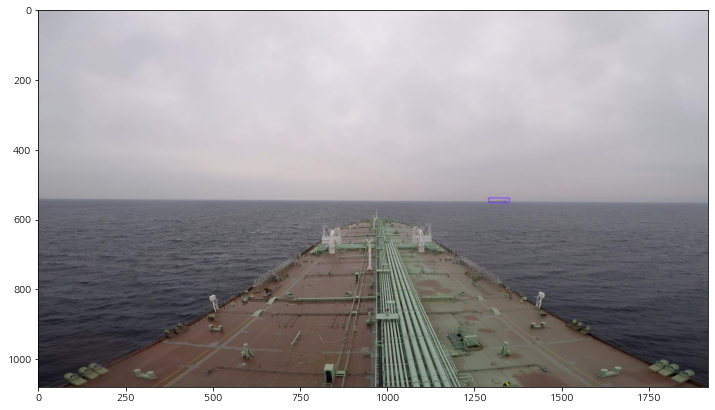

In [9]:
with open(raw_jsons[1]) as f:
    data = json.load(f)
    img_path = os.path.join(BASE_IMAGE_PATH, os.path.basename(data['data_key']))
    label_path = os.path.join(LABEL_JSON_PATH, os.path.basename(data['label_path'][0]))
    
    with open(label_path) as f2:
        data2 = json.load(f2)
        pp.pprint(data2)
        
        img = cv2.imread(img_path)
        bbox_info = data2['objects'][0]['annotation']
        
        pp.pprint(bbox_info)
        h = int(bbox_info['coord']['height'])
        w = int(bbox_info['coord']['width'])
        x = int(bbox_info['coord']['x'])
        y = int(bbox_info['coord']['y'])
        color = hex2rgb(bbox_info['meta']['color'])
        
        cv2.rectangle(img, (x, y), (x+w, y+h), color, 2)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## 4. K-Means에 사용될 w, h 정보 모두 받아오기

In [10]:
widths = []
heights = []
classes = []

def getLabel(x):
    if 'ship' in x:
        return 0
    elif 'misc' in x:
        return 1
    else:
        print(x)

for json_file in tqdm(raw_jsons):
    with open(json_file) as f:
        data = json.load(f)

        img_path = os.path.join(BASE_IMAGE_PATH, os.path.basename(data['data_key']))
        label_path = os.path.join(LABEL_JSON_PATH, os.path.basename(data['label_path'][0]))
        
        with open(label_path) as f2:
            data2 = json.load(f2)
            
            for anno in data2['objects']:
                bbox_info = anno['annotation']
                class_name = getLabel(anno['class_name'])
                
                h = int(bbox_info['coord']['height'])
                w = int(bbox_info['coord']['width'])
                x = int(bbox_info['coord']['x'])
                y = int(bbox_info['coord']['y'])
                
                classes.append(class_name)
                widths.append(w)
                heights.append(h)

100%|███████████████████████████| 14196/14196 [00:00<00:00, 18741.43it/s]


In [11]:
print(f"총 width 갯수: {len(widths)}")

총 width 갯수: 28825


### 데이터프레임 생성

In [12]:
df = pd.DataFrame({'width':widths, 'height':heights, 'class':classes})
df

,width,height,class
0,7,4,1
1,60,14,0
2,63,22,0
3,35,14,0
4,21,9,0
...,...,...,...
28820,26,11,0
28821,13,4,1
28822,9,5,1
28823,14,9,1


In [13]:
# groupby
df.groupby('class').mean()

,width,height
class,,
0,37.930094,15.682963
1,17.510352,7.982021


<AxesSubplot:xlabel='class', ylabel='count'>

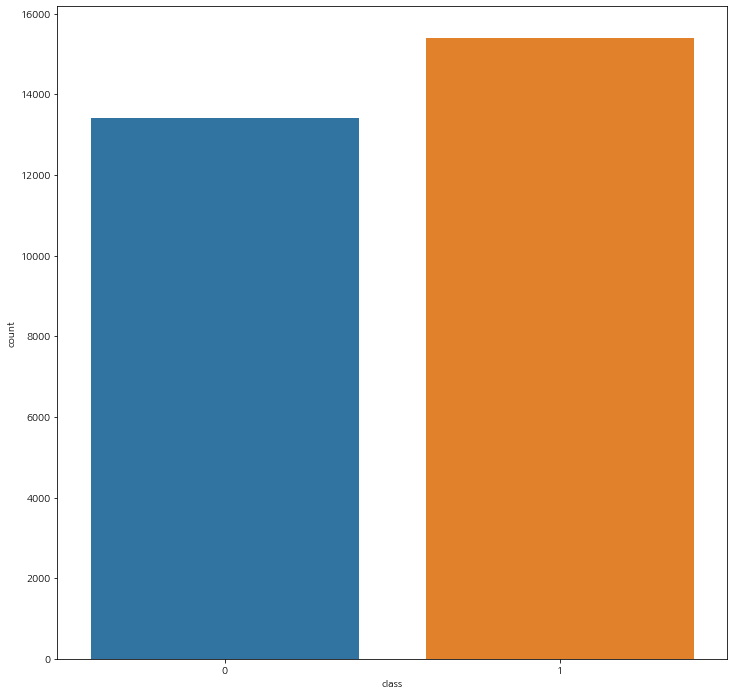

In [14]:
sns.countplot(df['class'])

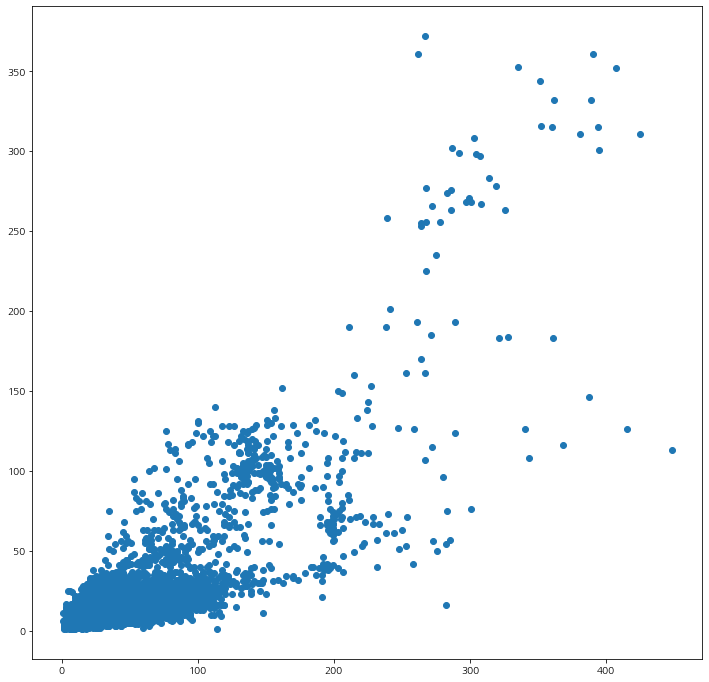

In [15]:
plt.scatter(widths, heights)

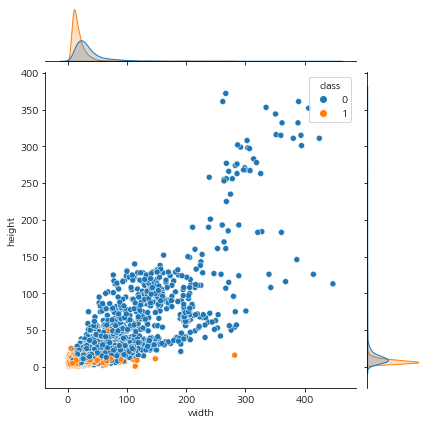

In [16]:
sns.jointplot(df['width'], df['height'], data=df, kind='scatter', hue=df['class'])

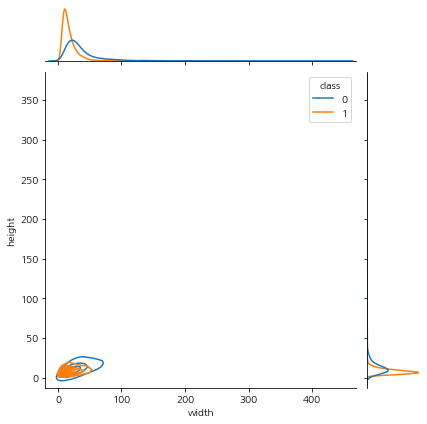

In [17]:
sns.jointplot(df['width'], df['height'], data=df, kind='kde', hue=df['class'])

## 5. K-Mean Clustering (K=5)

In [18]:
# 입력
X = df[['width', 'height']].values

In [19]:
km = KMeans(n_clusters=5, max_iter=10000, verbose=1, random_state=42)
labels = km.fit(X)

Initialization complete
Iteration 0, inertia 5412283.0
Iteration 1, inertia 3925641.586505513
Iteration 2, inertia 3828388.453835661
Iteration 3, inertia 3815142.217865646
Iteration 4, inertia 3811538.6032313756
Iteration 5, inertia 3810330.126576014
Iteration 6, inertia 3809487.5765955467
Iteration 7, inertia 3808919.3374093953
Converged at iteration 7: center shift 0.008107093522148187 within tolerance 0.04998797139312266.
Initialization complete
Iteration 0, inertia 7001090.0
Iteration 1, inertia 4026213.801187774
Iteration 2, inertia 3889403.247726375
Iteration 3, inertia 3853594.1621389417
Iteration 4, inertia 3835389.248460268
Iteration 5, inertia 3824931.5115022096
Iteration 6, inertia 3819278.2162126075
Iteration 7, inertia 3815297.773863163
Iteration 8, inertia 3812645.6305054626
Iteration 9, inertia 3811328.38152243
Iteration 10, inertia 3810081.068115507
Iteration 11, inertia 3809200.943941488
Iteration 12, inertia 3808911.9815608896
Converged at iteration 12: center shift 0

In [20]:
centers = km.cluster_centers_
centers

array([[ 14.43120085,   7.84366111],
       [ 76.60560345,  23.28017241],
       [164.10955056,  87.74438202],
       [ 35.        ,  12.10198169],
       [315.87272727, 252.92727273]])

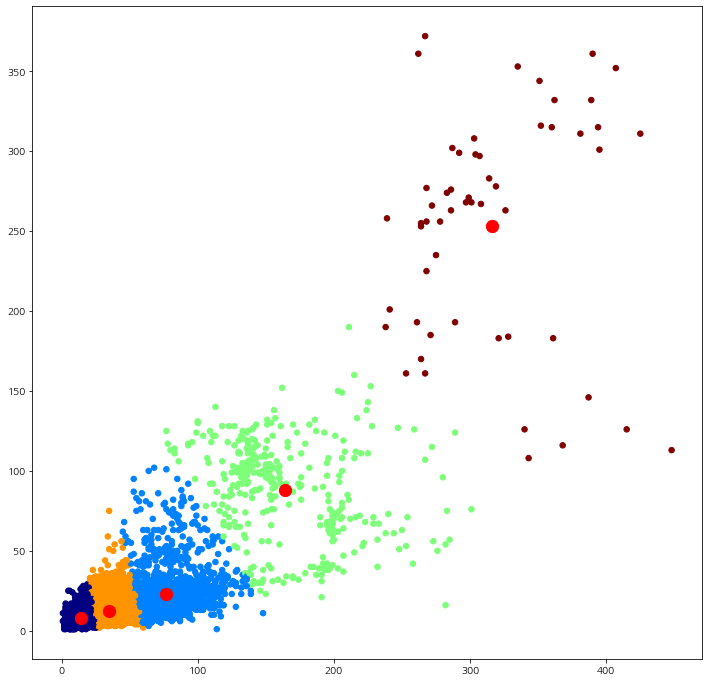

In [21]:
plt.scatter(X[:,0], X[:,1], s=30, c=labels.labels_, cmap='jet')

for x, y in centers:
    plt.scatter(x, y, s=150, c='r')

### 데이터가 퍼져있는 정도를 말하는 'Inertia'로 elbow cluster 찾기

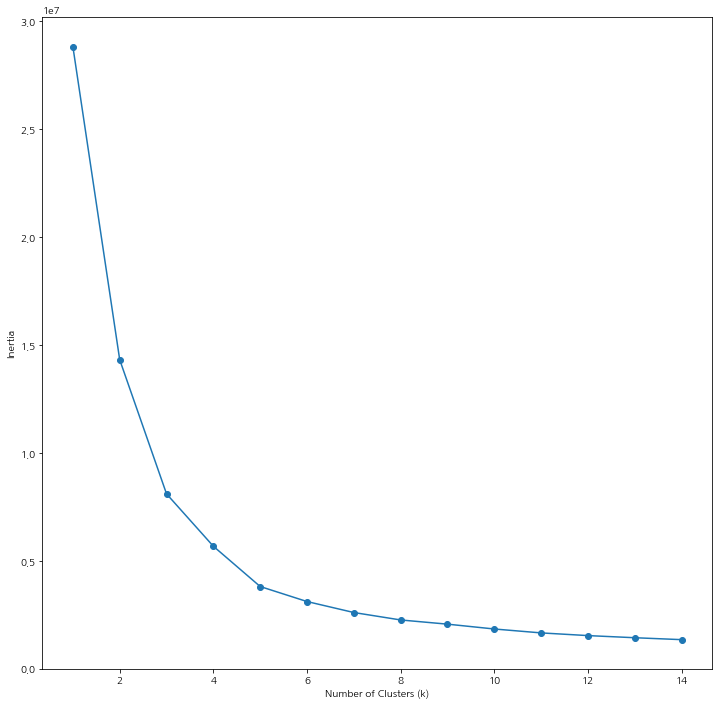

In [22]:
MAX_CLUSTER = 15
num_clusters = list(range(1, MAX_CLUSTER))
inertias = [] 
centers = []

for i in num_clusters:
    X = df[['width', 'height']].values
    
    km = KMeans(n_clusters=i)
    km.fit(X)
    centers.append(km.cluster_centers_)
    inertias.append(km.inertia_)
        
plt.plot(num_clusters, inertias, '-o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [36]:
# k = 4
ratios = []
for w, h in centers[3]:
    ratios.append(round(w/h, 2))
    
print(sorted(ratios))

[1.26, 1.91, 2.12, 3.24]


In [35]:
# k = 5
ratios = []
for w, h in centers[4]:
    ratios.append(round(w/h, 2))
    
print(sorted(ratios))

[1.25, 1.85, 1.87, 2.9, 3.28]


## 6. IoU 기반의 K-Mean Clustering

In [25]:
def iou(box, clusters):
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    
    if np.count_nonzero(x==0) > 0 or np.count_nonzero(y==0) > 0:
        raise ValueError("Box has no area")
    
    intersection = x*y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]
    
    iou_ = intersection / (box_area + cluster_area - intersection)
    
    return iou_

In [26]:
def avg_iou(boxes, clusters):
    return np.mean([np.max(iou(boxes[i], clusters)) for i in range(boxes.shape[0])])

In [27]:
def iou_based_kmeans(boxes, k, dist=np.median):
    rows = boxes.shape[0]
    
    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))

    np.random.seed()

    clusters = boxes[np.random.choice(rows, k, replace=False)]
    
    while True:
        for row in range(rows):
            distances[row] = 1 - iou(boxes[row], clusters)
            
        nearest_clusters = np.argmin(distances, axis=1)
        
        if (last_clusters == nearest_clusters).all():
            break
        
        for i in range(k):
            clusters[i] = dist(boxes[nearest_clusters == i], axis=0)
        
        last_clusters = nearest_clusters
        
    return clusters

In [29]:
N_CLUSTERS = 5
out = iou_based_kmeans(X, N_CLUSTERS)

print("Accuracy: {:.2f}%".format(avg_iou(X, out) * 100))
print("Boxes:\n {}".format(out))

ratios = np.around(out[:, 0] / out[:, 1], decimals=2).tolist()
inverse_ratios = np.around(out[:, 1] / out[:, 0], decimals=2).tolist()

print("Ratios:\n {}".format(sorted(ratios)))
print("Inverse Ratios:\n {}".format(sorted(inverse_ratios)))

Accuracy: 66.83%
Boxes:
 [[67 22]
 [14 10]
 [31 11]
 [10  6]
 [21  6]]
Ratios:
 [1.4, 1.67, 2.82, 3.05, 3.5]
Inverse Ratios:
 [0.29, 0.33, 0.35, 0.6, 0.71]


In [30]:
labels = [np.argmax(iou(X[i], out)) for i in range(X.shape[0])]
labels[:10]

[3, 0, 0, 2, 4, 1, 1, 1, 1, 2]

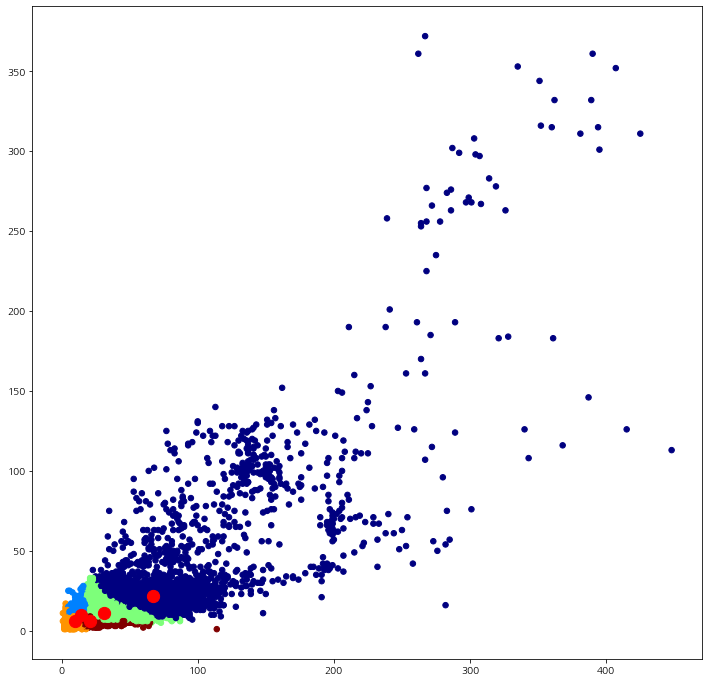

In [31]:
plt.scatter(X[:,0], X[:,1], s=30, c=labels, cmap='jet')

for x, y in out:
    plt.scatter(x, y, s=150, c='r')

In [32]:
ious = []
X = df[['width', 'height']].values

for k in range(2, 10):
    out = iou_based_kmeans(X, k)
    
    score = avg_iou(X, out) * 100
    ious.append(score)
    
    print("Accuracy: {:.2f}%".format(score))

Accuracy: 56.49%
Accuracy: 60.57%
Accuracy: 64.07%
Accuracy: 65.90%
Accuracy: 67.35%
Accuracy: 69.51%
Accuracy: 71.15%
Accuracy: 72.12%
Accuracy: 73.06%
Accuracy: 74.21%
Accuracy: 75.50%
Accuracy: 76.39%
Accuracy: 76.07%
Accuracy: 76.21%
Accuracy: 77.54%
Accuracy: 77.64%
Accuracy: 79.03%
Accuracy: 78.51%


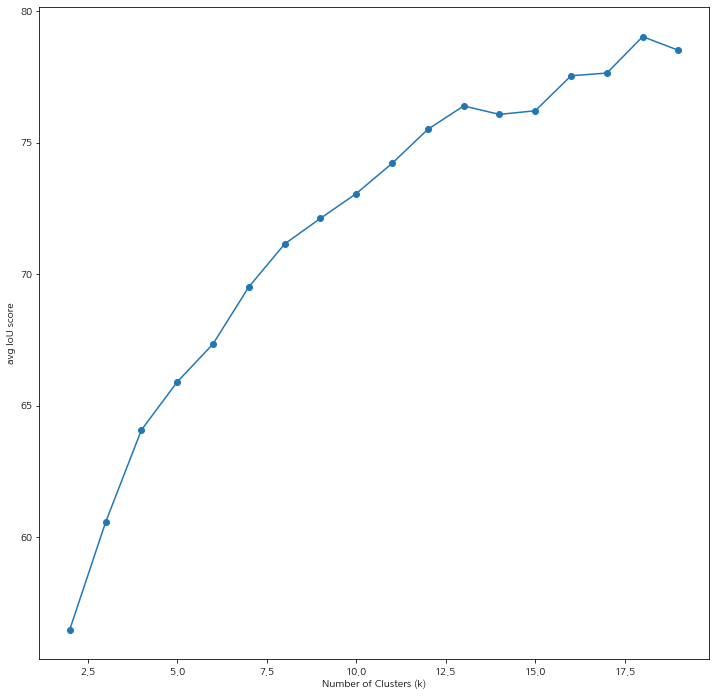

In [33]:
plt.plot(list(range(2, 20)), ious, '-o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('avg IoU score')
plt.show()

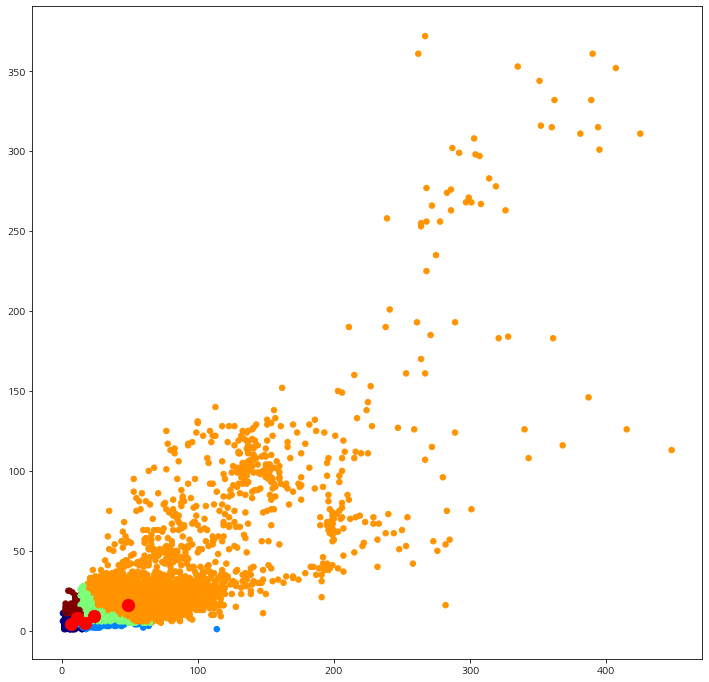

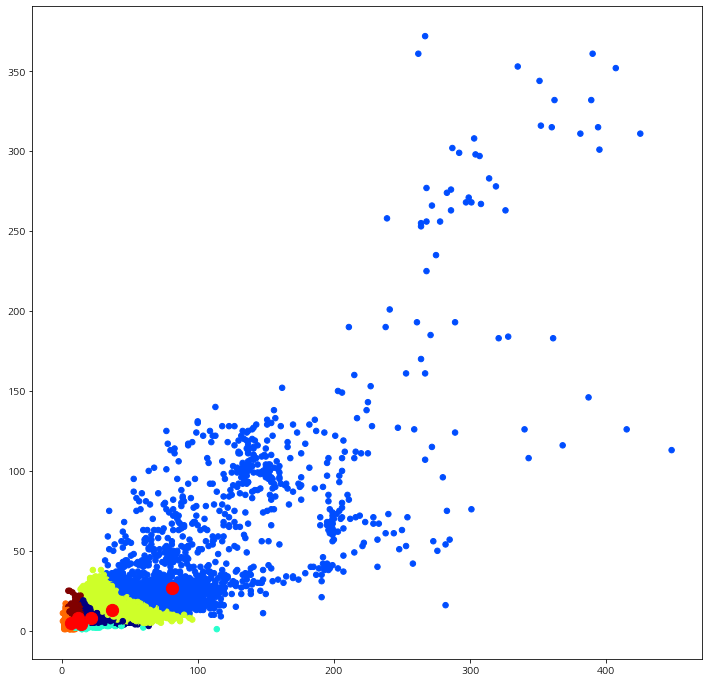

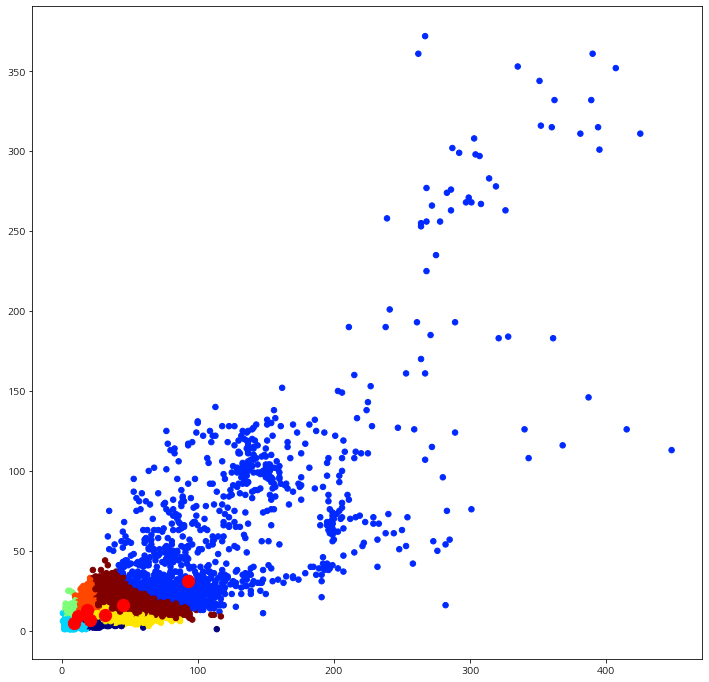

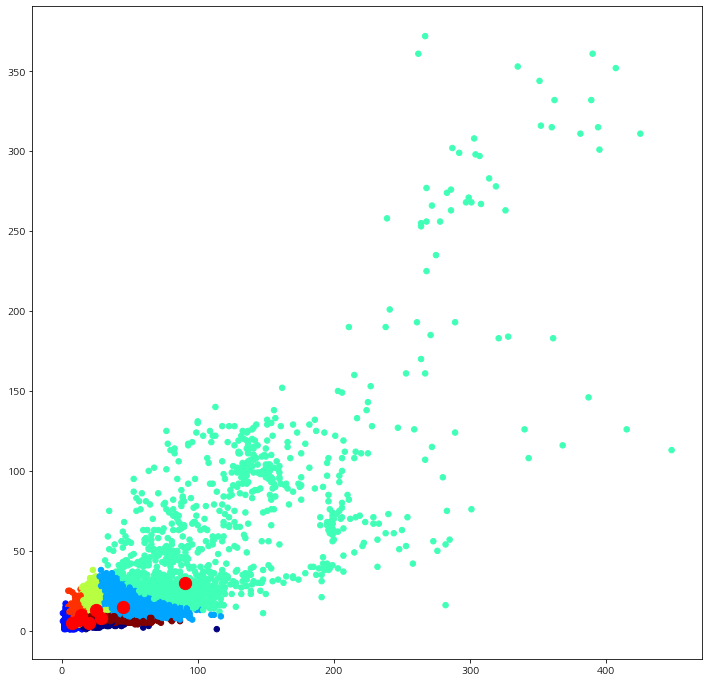

In [34]:
for k in range(5, 9):
    out = iou_based_kmeans(X, k)
    labels = [np.argmax(iou(X[i], out)) for i in range(X.shape[0])]
    
    plt.scatter(X[:,0], X[:,1], s=30, c=labels, cmap='jet')

    for x, y in out:
        plt.scatter(x, y, s=150, c='r')
    
    plt.show()